# 12_BANKSY_style_SIMBA.ipynb

BANKSY appends mean expression of genes of neighboring cells to the cell x gene matrix.

$$
\begin{bmatrix}
G_{c,i} \\
M_{N_{c}, i}
\end{bmatrix}
$$

They also include a Gabor like matrix to measure rotation invariant gradients of each gene. 

In SIMBA, we embed cells and genes in the same space. What if we create a separate "gene entity" referring to the mean expression of the neighbors? Thus our node types are Cell, Gene, and Gene_neighbors. Edges are only between cell-gene and cell-gene_neighbors.

One possible problem is that in aggregating the neighborhood information as a mean, we lose the distribution of the genes across the neighboring cells. But as an initial proof of concept/baseline, this is simpler to implement. 

1. BANKSY unifies cell typing and tissue domain segmentation for scalable spatial omics data analysis | Nature Genetics. https://www.nature.com/articles/s41588-024-01664-3.

In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.insert(1, '../scripts/benchmarking')

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import os
import simba as si
si.__version__

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [4]:
workdir = 'data/12'
si.settings.set_workdir(workdir)

Saving results in: data/12


In [5]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [6]:
import anndata as ad
from scipy.sparse import csr_matrix

# Test

In [111]:
adata_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC/151507.h5ad"
adata = sc.read_h5ad(adata_fn)

In [112]:
adata

AnnData object with n_obs × n_vars = 4221 × 15818
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Possible gene expression mean approaches:
- Mask with uniform weighting across genes in the neighborhood
- Gaussian/RBF kernel weighting based on distance of the cell in the neighborhood. 

In [9]:
# from manually added path
from spatial import gen_spatial_graph
from plot import plot_spatial_kernel

In [10]:
adata_CC = gen_spatial_graph(
    adata,
    e=500, # magnitude/mask
    scalar=1, # could be gene expression correlation?
    spatial_method='mask', 
)

In [11]:
# Remove self edge
diag_x, diag_y = np.diag_indices(adata_CC.X.shape[0])

adata_CC_diag = adata_CC.copy()
adata_CC_diag.X[diag_x, diag_y] = 0.0
adata_CC_diag.layers['simba'] = adata_CC_diag.X.copy()

(<Figure size 400x400 with 1 Axes>, <Axes: >)

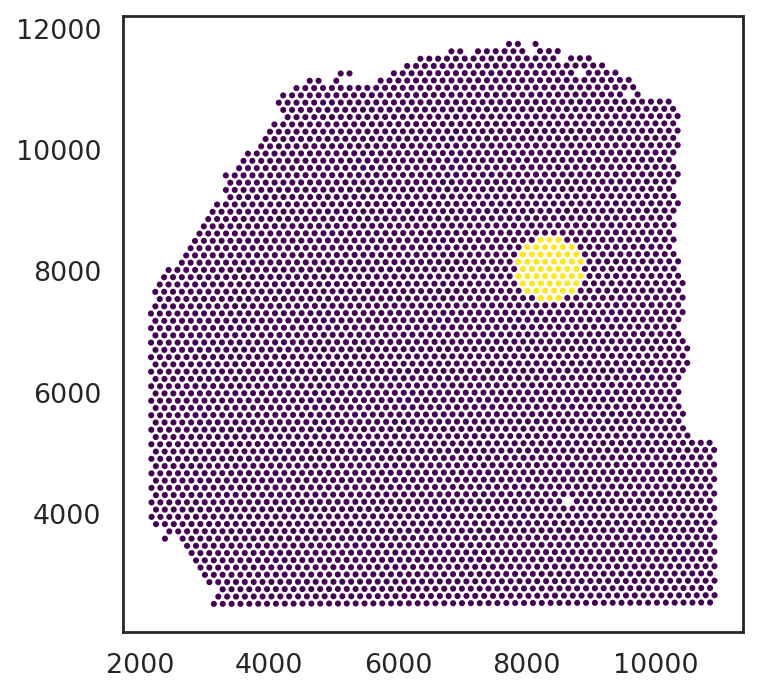

In [12]:
plot_spatial_kernel(adata_CC, barcode_idx=500)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

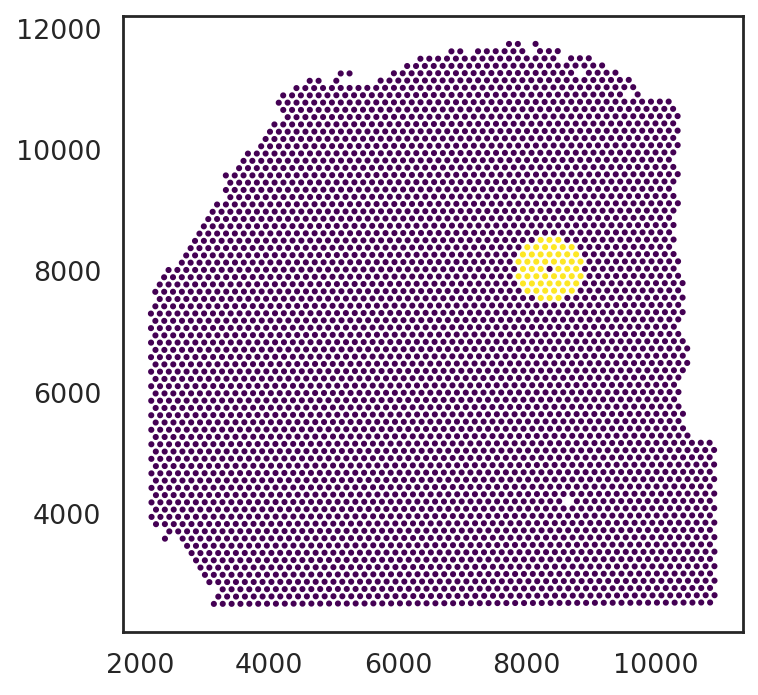

In [13]:
plot_spatial_kernel(adata_CC_diag, barcode_idx=500)

In [14]:
CC = np.array([ # 4x4
    [0, 1, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
])

CG = np.array([ # 4 cells x 2 genes
    [1, 2],
    [2, 4],
    [4, 8],
    [8, 16]
])

In [15]:
CC

array([[0, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

[CxC][CxG]

Columns of CxG is the expression of one gene across all cells. 

In [16]:
CC.sum(axis=1)

array([2, 1, 1, 1])

In [17]:
# norm weights
norm_CC = CC / CC.sum(axis=1)[:, np.newaxis]
np.matmul(norm_CC, CG)

array([[ 3.,  6.],
       [ 4.,  8.],
       [ 8., 16.],
       [ 1.,  2.]])

In [18]:
norm_CC

array([[0. , 0.5, 0.5, 0. ],
       [0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. ],
       [1. , 0. , 0. , 0. ]])

In [19]:
adata_CGN = adata_CC_diag.copy()
norm_neighbor_weights = adata_CGN.X.toarray() / adata_CGN.X.toarray().sum(axis=1)[:, np.newaxis]
adata_CGN.X = csr_matrix(norm_neighbor_weights)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

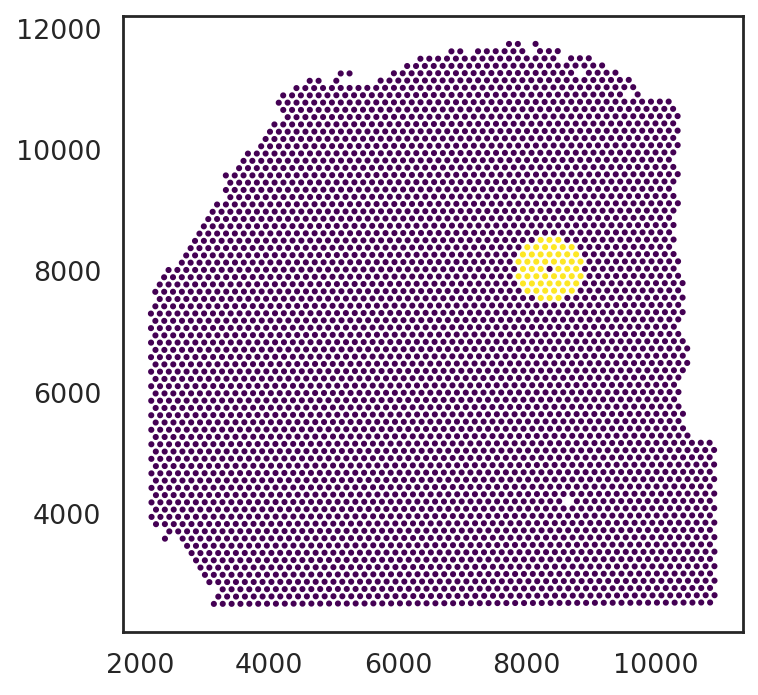

In [20]:
plot_spatial_kernel(adata_CGN, barcode_idx=500)

In [22]:
norm_neighbor_weights.shape

(4221, 4221)

In [23]:
weighted_avg_neighbors = np.matmul(norm_neighbor_weights, adata.X.toarray())

In [25]:
adata_N = adata.copy()
adata_N.X = csr_matrix(weighted_avg_neighbors)

In [28]:
import squidpy as sq

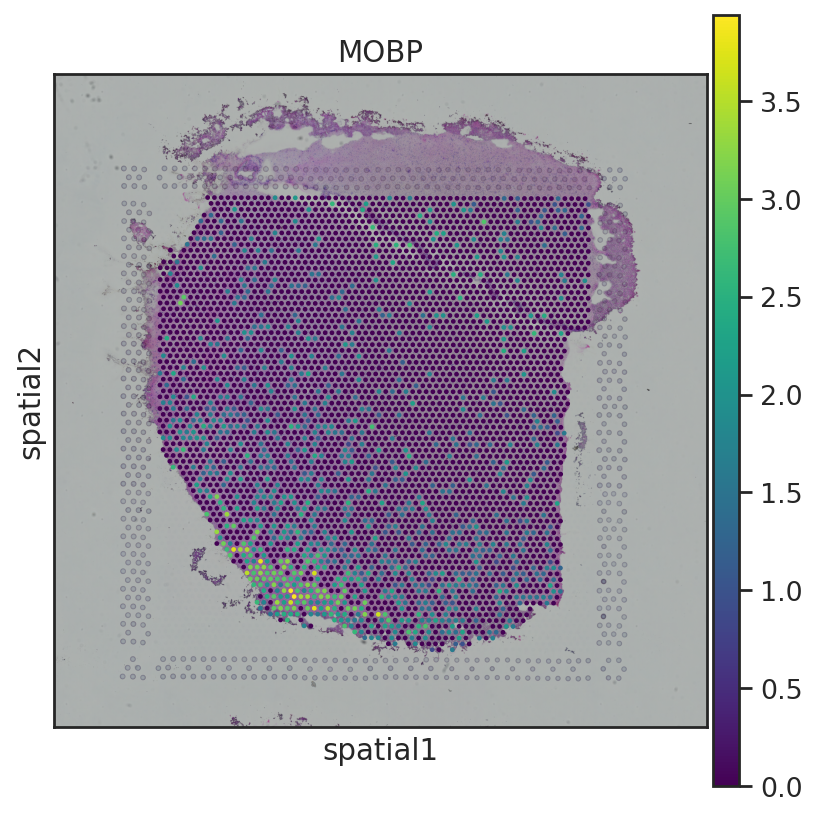

In [36]:
sq.pl.spatial_scatter(adata, color="MOBP", size=1, linewidth=0)

In [ ]:
# adata_N.var_names = 
new_gene_names = [ f"{X}_mean" for X in adata_N.var_names]
new_gene_names[:5]

In [ ]:
adata_N.var_names = new_gene_names

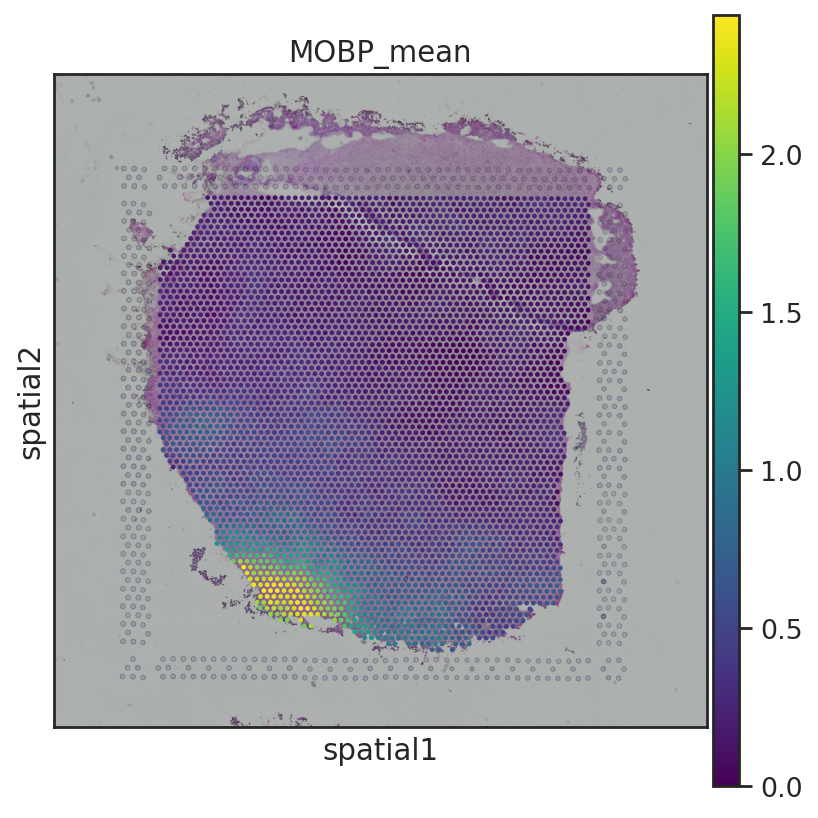

In [45]:
sq.pl.spatial_scatter(adata_N, color="MOBP_mean", linewidth=0)

# SIMBA on neighbor means alone

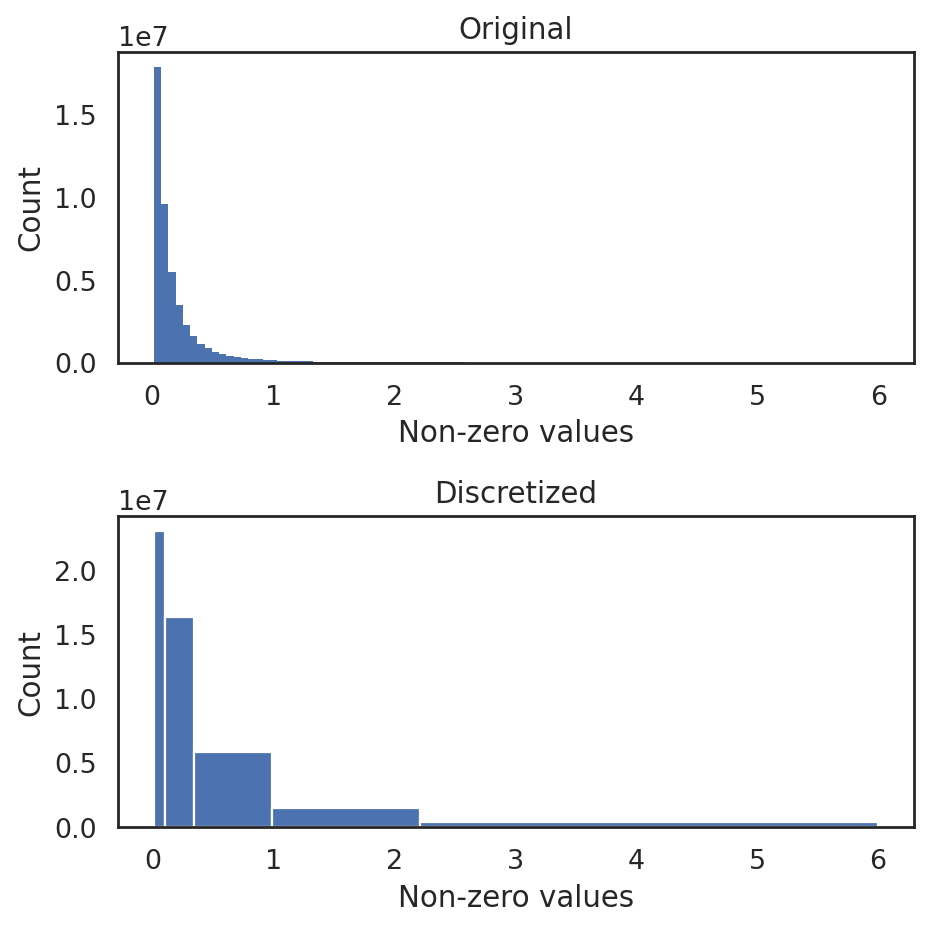

In [46]:
si.tl.discretize(adata_N,n_bins=5)
si.pl.discretize(adata_N,kde=False)

In [47]:
si.tl.gen_graph(
    list_CG=[adata_N],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_neighbors_only'
)

relation0: source: C, destination: G
#edges: 23048229
relation1: source: C, destination: G
#edges: 16329062
relation2: source: C, destination: G
#edges: 5800156
relation3: source: C, destination: G
#edges: 1496088
relation4: source: C, destination: G
#edges: 351332
Total number of edges: 47024867
Writing graph file "pbg_graph.txt" to "data/12/pbg/graph_neighbors_only" ...
Finished.


In [48]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_neighbors_only')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000754
Weight decay being used for training is 0.000754
Converting input data ...
[2025-02-27 17:50:32.366982] Using the 5 relation types given in the config
[2025-02-27 17:50:32.367377] Searching for the entities in the edge files...
[2025-02-27 17:51:26.229837] Entity type C:
[2025-02-27 17:51:26.231037] - Found 4221 entities
[2025-02-27 17:51:26.231350] - Removing the ones with fewer than 1 occurrences...
[2025-02-27 17:51:26.232266] - Left with 4221 entities
[2025-02-27 17:51:26.232565] - Shuffling them...
[2025-02-27 17:51:26.234608] Entity type G:
[2025-02-27 17:51:26.234898] - Found 15818 entities
[2025-02-27 17:51:26.235170] - Removing the ones with fewer than 1 occurrences...
[2025-02-27 17:51:26.237859] - Left with 15818 entities
[2025-02-27 17:51:26.238137] - Shuffling them...
[2025-02-27 17:51:26.245408] Preparing counts and dictionaries for entities and relation types:
[2025-02-27 17:51:26.

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:


[2025-02-27 17:55:23.031690] - Processed 47024867 edges in total
Starting training ...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/c

Finished


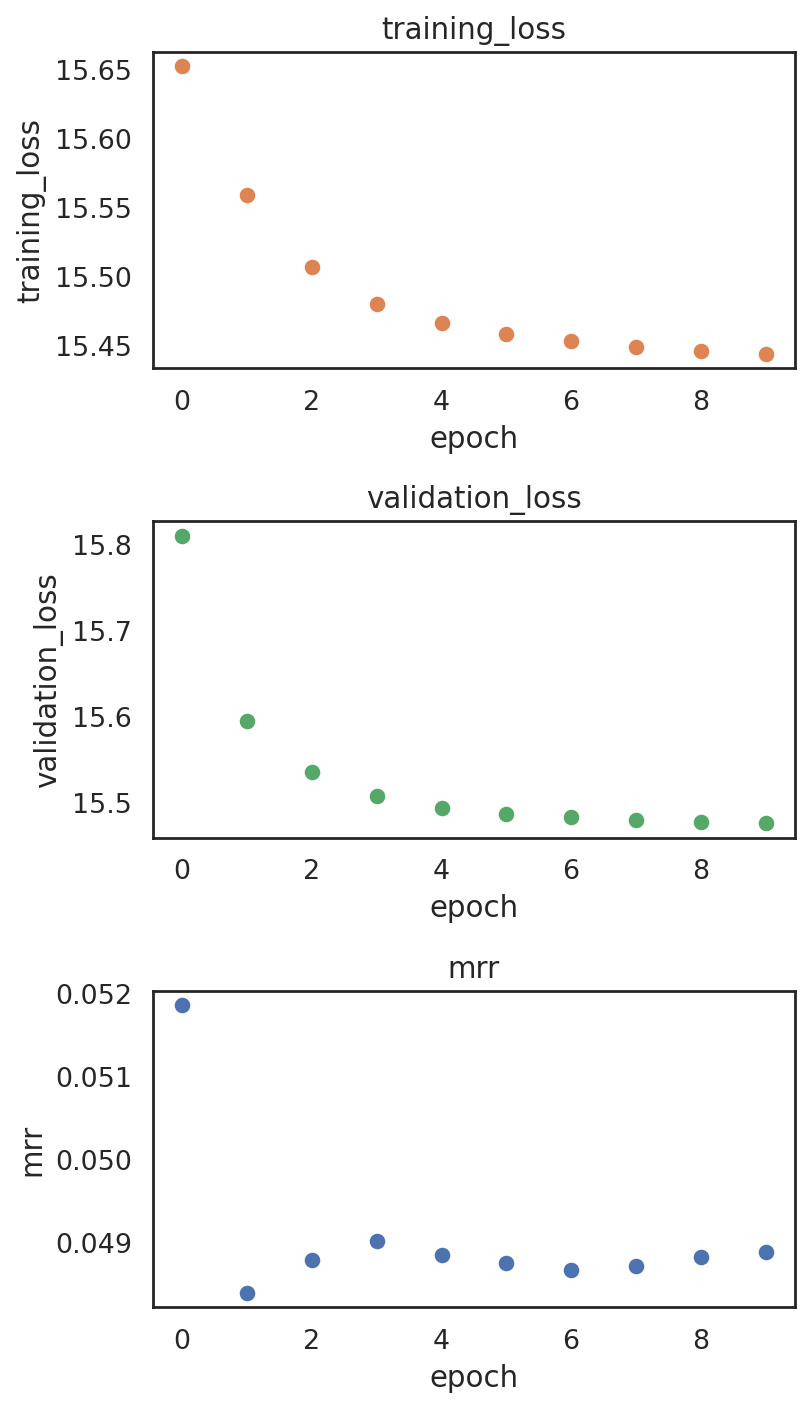

In [49]:
si.pl.pbg_metrics(fig_ncol=1)

In [50]:
# read in entity embeddings obtained from pbg training.
neighbors_only_dict_adata = si.read_embedding()
neighbors_only_dict_adata

{'C': AnnData object with n_obs × n_vars = 4221 × 50,
 'G': AnnData object with n_obs × n_vars = 15818 × 50}

In [90]:
nonly_adata_C = neighbors_only_dict_adata['C']  # embeddings of cells
nonly_adata_G = neighbors_only_dict_adata['G']  # embeddings of cells
nonly_adata_C.obs['spatialLIBD'] = adata[nonly_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
nonly_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'
    uns: 'color'
    obsm: 'X_umap'

In [91]:
nonly_adata_C.X

array([[ 0.23916337,  0.02296524, -0.14291535, ...,  0.07252827,
         0.1959068 , -0.24240999],
       [ 0.26893523,  0.03576897,  0.30437478, ...,  0.19128035,
        -0.23690453, -0.31505147],
       [ 0.05398642,  0.27086344,  0.2452076 , ...,  0.09363168,
         0.55231315,  0.17125534],
       ...,
       [-0.18664996,  0.18129094, -0.33919132, ...,  0.2670366 ,
        -0.1030048 ,  0.02434813],
       [ 0.31541336, -0.1256212 , -0.19650644, ...,  0.27957264,
        -0.24079223,  0.1075629 ],
       [ 0.3789324 ,  0.24399361, -0.47049114, ...,  0.33801836,
        -0.04302413,  0.40184683]], dtype=float32)

In [92]:
from cluster import get_pairwise_distance
from sklearn.metrics import silhouette_score

In [93]:
dists = get_pairwise_distance(nonly_adata_C.X) # on the data in X
sil = silhouette_score(X=dists, labels=nonly_adata_C.obs['spatialLIBD'])
sil

0.020859089

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


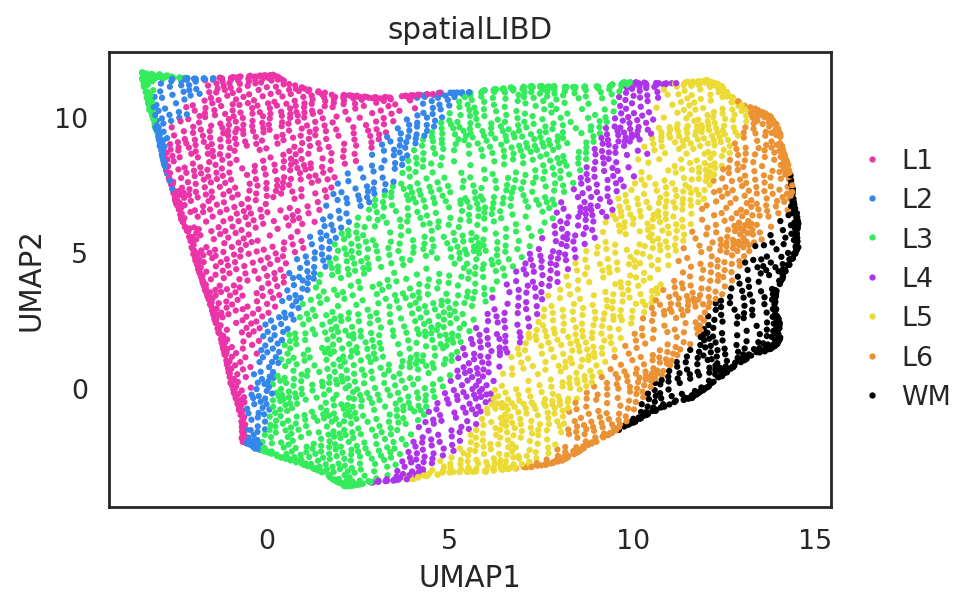

In [94]:
si.tl.umap(nonly_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    nonly_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

Using the weighted means (with a simple binary mask) introduces high levels of correlation between nearby spots.

In [95]:
nonly_adata_C.write(f"{workdir}/nonly_adata_C.h5ad")
nonly_adata_G.write(f"{workdir}/nonly_adata_G.h5ad")

# SIMBA on combined 

Note: adata_N already based on normalized data...

Discretize AFTER concatenation.

Alternative: apply lambda in the training weight parameters rather than at this stage. Would need to establish two different "gene" entities

In [121]:
def combine_adatas(lambda_val, adata_CG, adata_CGN):
    scaled_adata_CG = adata_CG.copy()
    scaled_adata_CG.X = np.sqrt(1 - lambda_val) * scaled_adata_CG.X

    scaled_adata_CGN = adata_CGN.copy()
    scaled_adata_CGN.X = np.sqrt(lambda_val) * scaled_adata_CGN.X
    banksy_adata = ad.concat([scaled_adata_CG, scaled_adata_CGN], axis=1)
    banksy_adata.layers['counts'] = csr_matrix(banksy_adata.X)
    return banksy_adata

In [123]:
adata_N_raw = adata.copy()
adata_N_raw.X = csr_matrix(weighted_avg_neighbors)
# adata_N.var_names = 
new_gene_names = [ f"{X}_mean" for X in adata_N.var_names]
adata_N_raw.var_names = new_gene_names

## SIMBA local

In [124]:
banksy_local_adata = combine_adatas(lambda_val=0.2, adata_CG=adata, adata_CGN=adata_N_raw) #

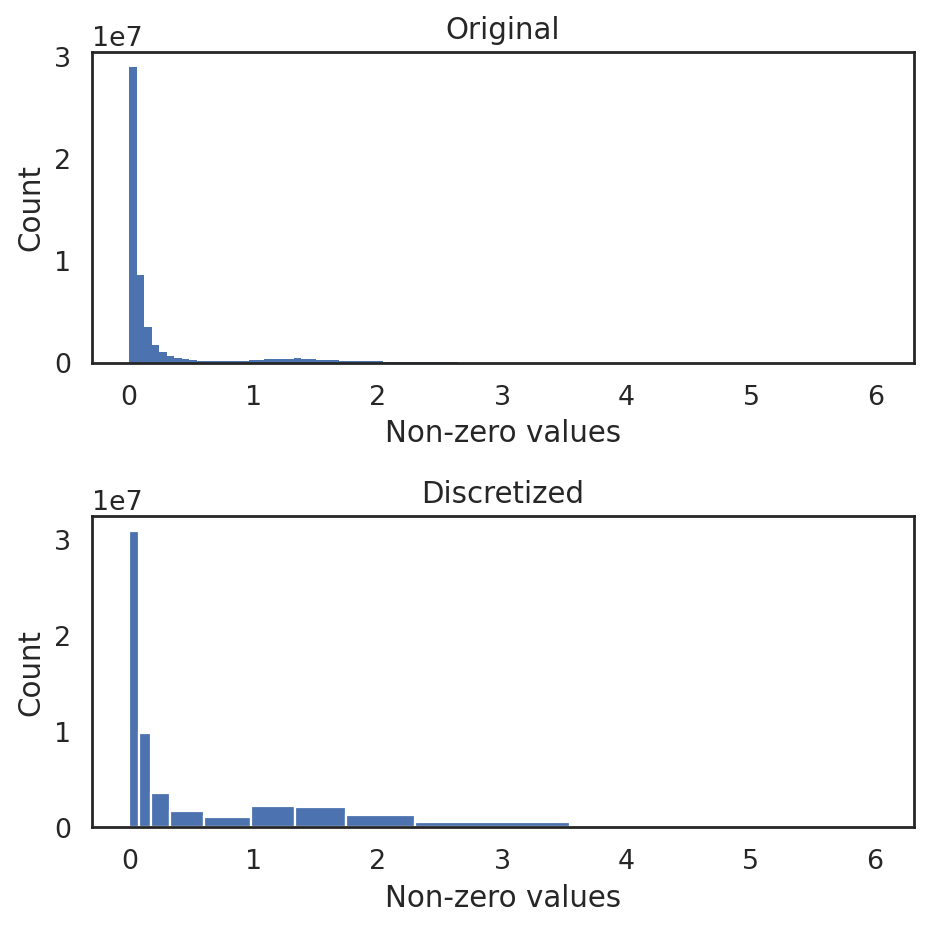

In [125]:
si.tl.discretize(banksy_local_adata,n_bins=10)
si.pl.discretize(banksy_local_adata,kde=False)

In [128]:
si.tl.gen_graph(
    list_CG=[banksy_local_adata],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_local'
)

relation0: source: C, destination: G
#edges: 30869333
relation1: source: C, destination: G
#edges: 9831870
relation2: source: C, destination: G
#edges: 3552108
relation3: source: C, destination: G
#edges: 1621059
relation4: source: C, destination: G
#edges: 1009952
relation5: source: C, destination: G
#edges: 2156600
relation6: source: C, destination: G
#edges: 2109882
relation7: source: C, destination: G
#edges: 1253529
relation8: source: C, destination: G
#edges: 505173
relation9: source: C, destination: G
#edges: 47570
Total number of edges: 52957076
Writing graph file "pbg_graph.txt" to "data/12/pbg/graph_local" ...
Finished.


In [129]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_local')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000446
Weight decay being used for training is 0.000446
Converting input data ...
[2025-02-27 18:57:03.147468] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-02-27 18:57:03.147952] These files are in: data/12/pbg/graph_local/input/entity, data/12/pbg/graph_local/input/edge
Starting training ...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/c

Finished


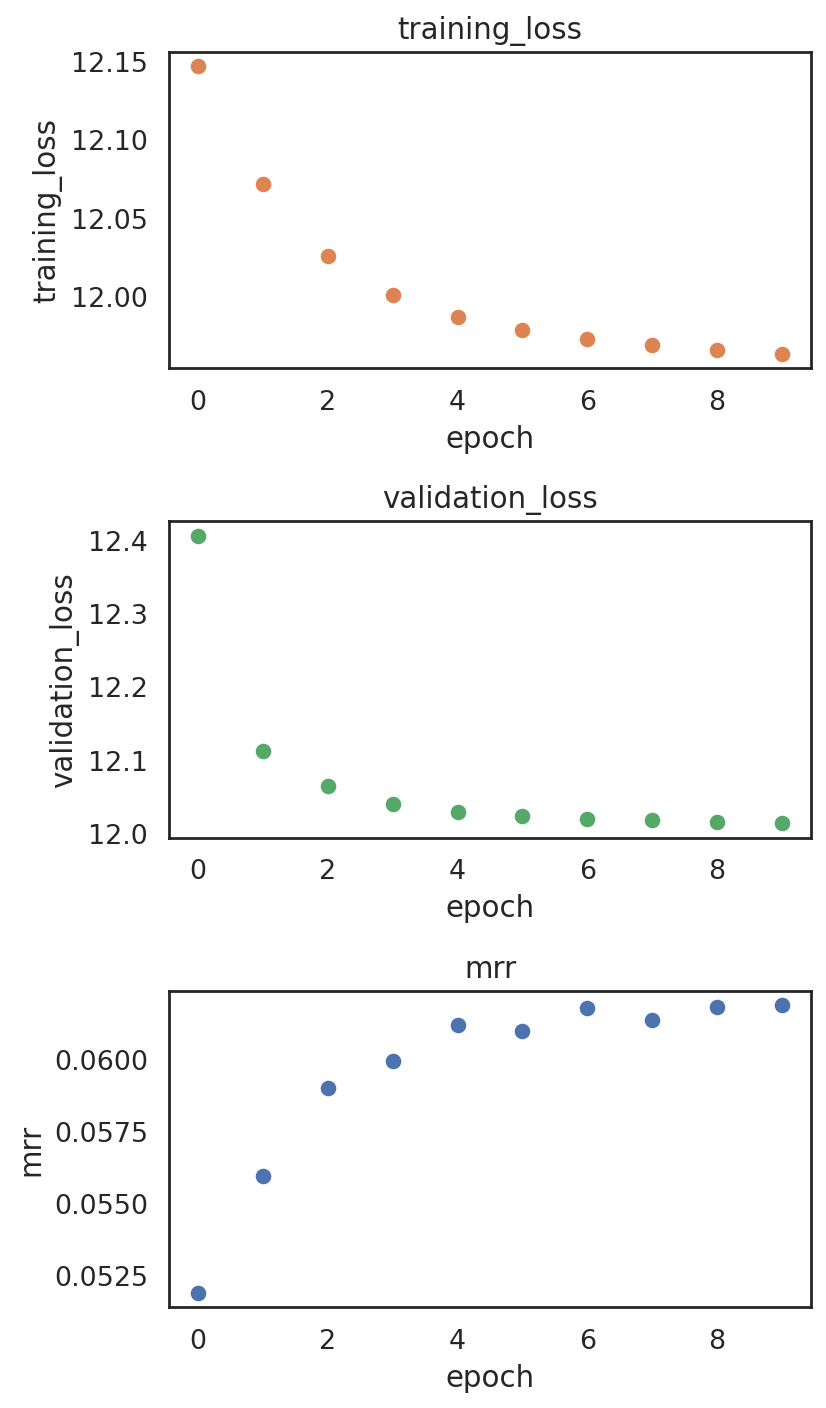

In [130]:
si.pl.pbg_metrics(fig_ncol=1)

In [134]:
# read in entity embeddings obtained from pbg training.
local_dict_adata = si.read_embedding()
local_dict_adata

{'C': AnnData object with n_obs × n_vars = 4221 × 50,
 'G': AnnData object with n_obs × n_vars = 31636 × 50}

In [135]:
local_adata_C = local_dict_adata['C']  # embeddings of cells
local_adata_G = local_dict_adata['G']
local_adata_C.obs['spatialLIBD'] = adata[local_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
local_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


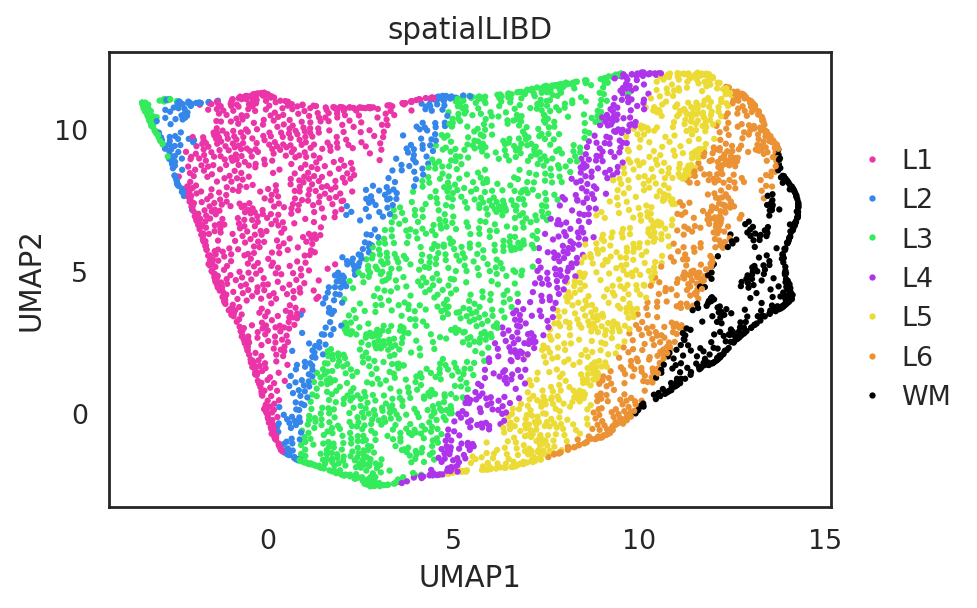

In [136]:
si.tl.umap(local_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    local_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [137]:
local_adata_C.write(f"{workdir}/local_adata_C.h5ad")
local_adata_G.write(f"{workdir}/local_adata_G.h5ad")

## SIMBA domain

In [139]:
banksy_domain_adata = combine_adatas(lambda_val=0.8, adata_CG=adata, adata_CGN=adata_N_raw)

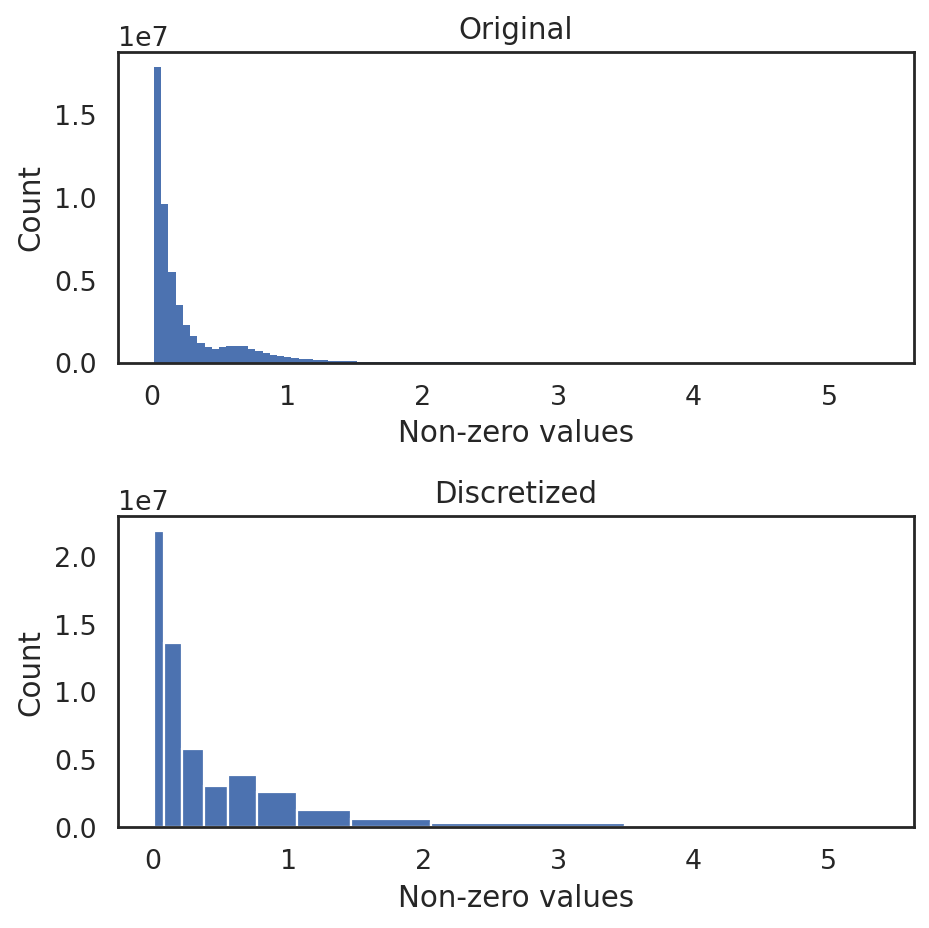

In [141]:
si.tl.discretize(banksy_domain_adata,n_bins=10)
si.pl.discretize(banksy_domain_adata,kde=False)

In [142]:
si.tl.gen_graph(
    list_CG=[banksy_domain_adata],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_domain'
)

relation0: source: C, destination: G
#edges: 21922447
relation1: source: C, destination: G
#edges: 13622507
relation2: source: C, destination: G
#edges: 5774790
relation3: source: C, destination: G
#edges: 3034842
relation4: source: C, destination: G
#edges: 3830594
relation5: source: C, destination: G
#edges: 2599665
relation6: source: C, destination: G
#edges: 1246869
relation7: source: C, destination: G
#edges: 586145
relation8: source: C, destination: G
#edges: 297557
relation9: source: C, destination: G
#edges: 41660
Total number of edges: 52957076
Writing graph file "pbg_graph.txt" to "data/12/pbg/graph_domain" ...
Finished.


In [143]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_domain')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000446
Weight decay being used for training is 0.000446
Converting input data ...
[2025-02-27 19:27:49.900338] Using the 10 relation types given in the config
[2025-02-27 19:27:49.901041] Searching for the entities in the edge files...
[2025-02-27 19:28:51.973797] Entity type C:
[2025-02-27 19:28:51.975291] - Found 4221 entities
[2025-02-27 19:28:51.975626] - Removing the ones with fewer than 1 occurrences...
[2025-02-27 19:28:51.976498] - Left with 4221 entities
[2025-02-27 19:28:51.976787] - Shuffling them...
[2025-02-27 19:28:51.978907] Entity type G:
[2025-02-27 19:28:51.979204] - Found 31636 entities
[2025-02-27 19:28:51.979483] - Removing the ones with fewer than 1 occurrences...
[2025-02-27 19:28:51.983817] - Left with 31636 entities
[2025-02-27 19:28:51.984129] - Shuffling them...
[2025-02-27 19:28:51.999054] Preparing counts and dictionaries for entities and relation types:
[2025-02-27 19:28:52

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/c

Finished


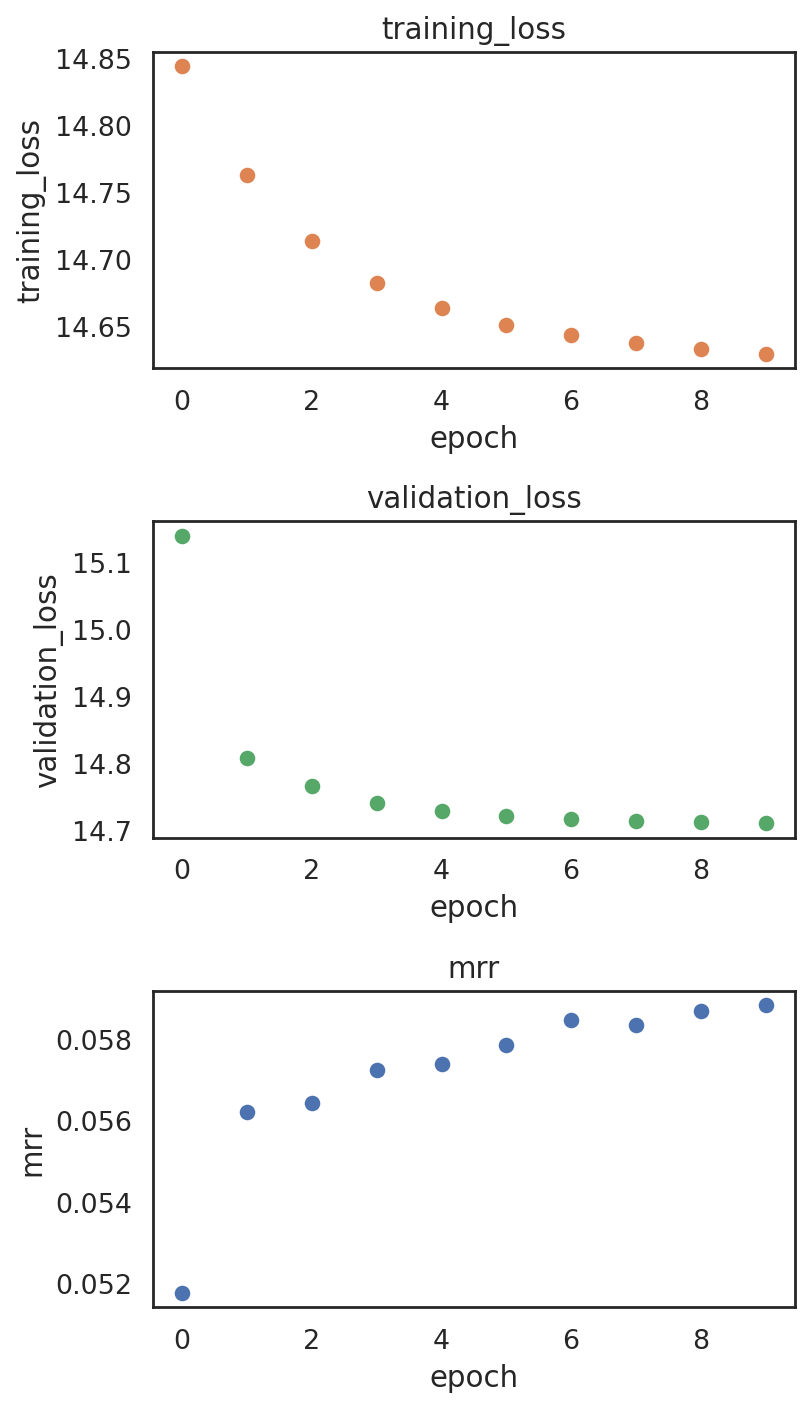

In [145]:
si.pl.pbg_metrics(fig_ncol=1)

In [146]:
# read in entity embeddings obtained from pbg training.
domain_dict_adata = si.read_embedding()
domain_adata_G = domain_dict_adata['G']
domain_adata_C = domain_dict_adata['C']  # embeddings of cells
domain_adata_C.obs['spatialLIBD'] = adata[domain_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
domain_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


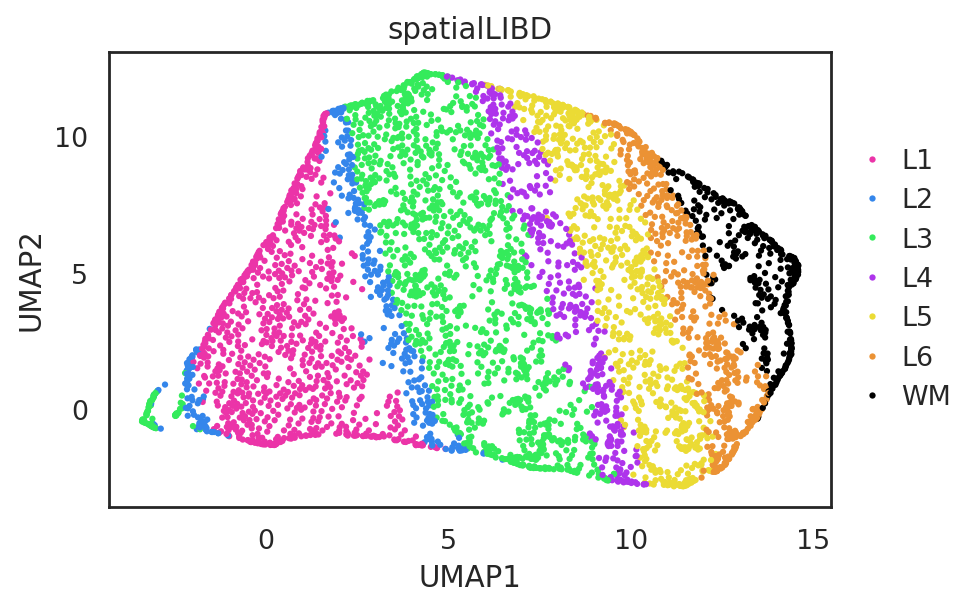

In [147]:
si.tl.umap(domain_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    domain_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [148]:
domain_adata_C.write(f"{workdir}/domain_adata_C.h5ad")
domain_adata_G.write(f"{workdir}/domain_adata_G.h5ad")